In [60]:
import tensorflow as tf
import os
import numpy as np

IMAGE_SIZE = 32

def load_data_from_file(file_path, labels_number=1):
    with open(file_path, 'rb') as f:
        data = f.read()
    offset = 0
    max_offset = len(data) - 1
    coarse_labels = []
    fine_labels = []
    images = []
    while offset < max_offset:
        labels = np.frombuffer(data, dtype=np.uint8, count=labels_number, offset=offset).reshape((labels_number,))
        offset += labels_number
        img = (np.frombuffer(data, dtype=np.uint8, count=3072, offset=offset).reshape((3, IMAGE_SIZE, IMAGE_SIZE)).transpose((1, 2, 0)))
        offset += 3072
        coarse_labels.append(labels[0])
        fine_labels.append(labels[1])
        images.append(img)
    return [np.array(coarse_labels), np.array(fine_labels), np.array(images)]

def load_labels_from_file(file_path):
    return np.genfromtxt(file_path, comments="#", delimiter=",", dtype='str')

def load_cifar100_dataset():
    url = "https://www.cs.toronto.edu/~kriz/cifar-100-binary.tar.gz"
    dataset_file = tf.keras.utils.get_file("cifar.tar.gz", url, untar=True, cache_dir='.', cache_subdir='')
    dataset_dir = os.path.join(os.path.dirname(dataset_file), 'cifar-100-binary')

    CY_train, FY_train, X_train = load_data_from_file(os.path.join(dataset_dir, 'train.bin'), labels_number=2)
    CY_test, FY_test, X_test = load_data_from_file(os.path.join(dataset_dir, 'test.bin'), labels_number=2)

    C_label = np.genfromtxt(os.path.join(dataset_dir, 'coarse_label_names.txt'), comments="#", delimiter=",", dtype='str')
    F_label = np.genfromtxt(os.path.join(dataset_dir, 'fine_label_names.txt'), comments="#", delimiter=",", dtype='str')

    return X_train, CY_train, FY_train, X_test, CY_test, FY_test, C_label, F_label

In [32]:
X_train, CY_train, FY_train, X_test, CY_test, FY_test, C_label, F_label = load_cifar100_dataset()

In [33]:
print(images_train.shape, coarse_labels_train.shape, fine_labels_train.shape)

(50000, 32, 32, 3) (50000,) (50000,)


In [25]:
X_train, X_test = X_train / 255.0, X_test / 255.0

In [34]:
def view_dataset(classnames, label, images):
    plt.figure(figsize=(12,12))
    for i in range(120):
        plt.subplot(10,12,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(classnames[label[i]], labelpad=2, fontsize=6)
    plt.show()

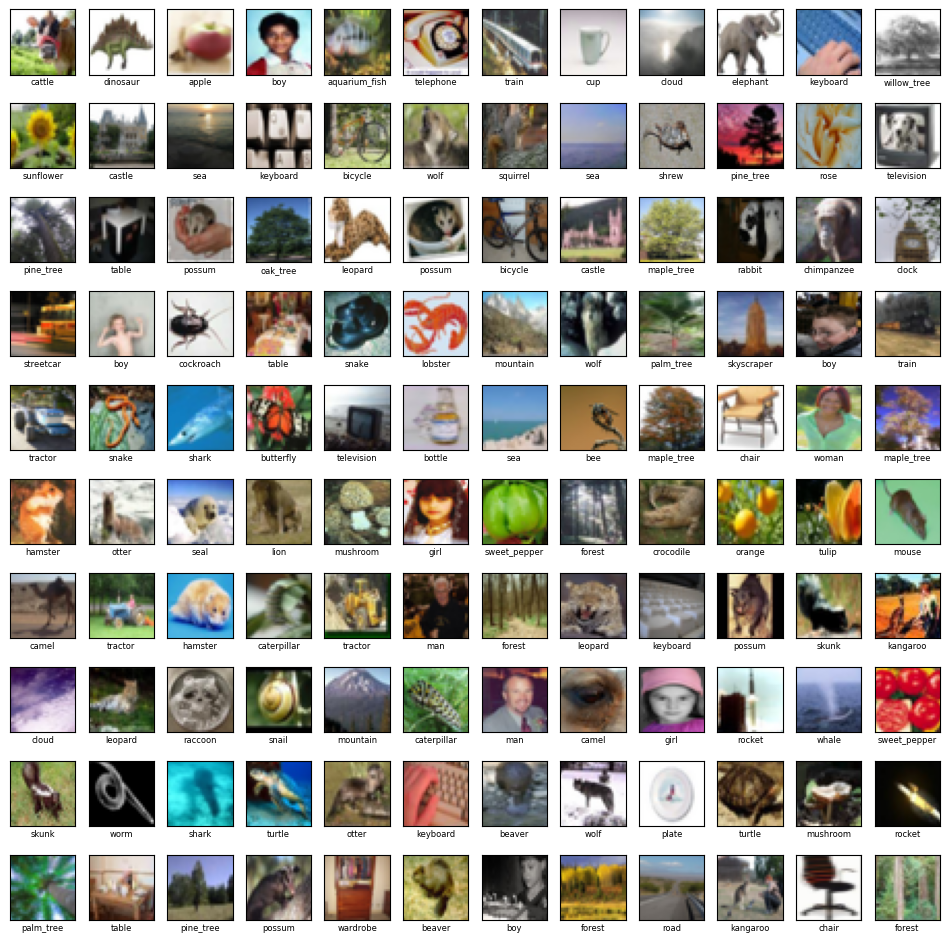

In [35]:
import matplotlib.pyplot as plt


view_dataset(F_label, FY_train, X_train)

In [36]:
view_dataset(C_label, CY_train, X_train)

In [12]:
from tensorflow.keras import layers, models

def getModel():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(100, activation='softmax'))
    return model

In [13]:
model = getModel()

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

**Какие элементы сети зависят от количества цветов, какие — от количества классов?**

Количество цветов влияет на конфигурацию входных слоев и размеры весовых тензоров, а количество классов влияет на конфигурацию выходного слоя, функцию активации и функцию потерь для правильной классификации изображений в задаче классификации.


**Объяснение места в модели каждого слоя, обоснование выбора гиперпараметров.**

1. Входной слой представляет собой изображения размером 32x32 пикселя с тремя цветовыми каналами (RGB). Размер входных данных определяется размерами изображений и количеством цветовых каналов. В данном случае, изображения CIFAR-10 имеют 32x32x3 пикселя, что определяет размер входных данных

2. Сверточные слои идут после входного слоя. Обычно включают несколько сверточных слоев с пулингом. Сверточные слои выполняют операции свертки и пулинга для извлечения признаков из изображений. Гиперпараметры сверточных слоев, такие как количество фильтров, размеры фильтров, шаг свертки (stride) и тип пулинга, выбираются на основе экспериментов и могут зависеть от сложности задачи.

3. Полносвязанные слои следуют за сверточными слоями и представляют собой плоский вектор признаков для каждого изображения. Полносвязанные слои принимают высокоуровневые признаки из сверточных слоев и выполняют классификацию. Гиперпараметры полносвязных слоев, такие как количество нейронов и функции активации, выбираются на основе экспериментов.

4. Выходной слой находится в конце модели и отвечает за предсказание классов. Выходной слой должен иметь столько нейронов, сколько классов в задаче классификации (в случае CIFAR-10 - 10 классов). Функция активации на выходном слое обычно является softmax для многоклассовой классификации.

5. Функция потерь и оптимизатор:
Эти элементы определяются при компиляции модели. Выбор функции потерь и оптимизатора зависит от задачи классификации и могут быть выбраны на основе принципов обучения нейронных сетей.

Общие гиперпараметры, такие как количество сверточных слоев, размер фильтров, количество нейронов в полносвязных слоях и скорость обучения, выбираются на основе экспериментов и подбираются таким образом, чтобы обеспечить хорошую производительность модели на задаче классификации CIFAR-10.

In [39]:
def getCompiledModel():
    model = getModel()
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])
    return model

**Обучение на 20 широких классах**

In [40]:
model = getCompiledModel()

In [41]:
his = model.fit(X_train, CY_train, epochs=20)

Epoch 1/20


C:\Users\Sphex\anaconda3\Lib\site-packages\keras\src\backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 21s 13ms/step - loss: 2.5808 - accuracy: 0.2382
Epoch 2/20
1563/1563 [==============================] - 21s 13ms/step - loss: 2.1638 - accuracy: 0.3327
Epoch 3/20
1563/1563 [==============================] - 21s 14ms/step - loss: 1.9986 - accuracy: 0.3806
Epoch 4/20
1563/1563 [==============================] - 22s 14ms/step - loss: 1.8871 - accuracy: 0.4157
Epoch 5/20
1563/1563 [==============================] - 22s 14ms/step - loss: 1.8018 - accuracy: 0.4419
Epoch 6/20
1563/1563 [==============================] - 22s 14ms/step - loss: 1.7178 - accuracy: 0.4640
Epoch 7/20
1563/1563 [==============================] - 22s 14ms/step - loss: 1.6475 - accuracy: 0.4856
Epoch 8/20
1563/1563 [==============================] - 22s 14ms/step - loss: 1.5699 - accuracy: 0.5104
Epoch 9/20
1563/1563 [==============================] - 22s 14ms/step - loss: 1.5194 - accuracy: 0.5218
Epoch 10/20
1563/1563 [==============================] - 22s 14ms/step - lo

In [42]:
model.save('./coarse_model.keras')

Точность на тестовых данных

In [43]:
С_test_loss, С_test_acc = model.evaluate(X_test, CY_test)

print('\nТочность на тестовых данных:', С_test_acc)

313/313 [==============================] - 2s 5ms/step - loss: 2.2845 - accuracy: 0.4399

Точность на тестовых данных: 0.4399000108242035


In [47]:
С_predictions = model.predict(X_test)
С_predictions = np.argmax(С_predictions, axis=-1)
from sklearn.metrics import classification_report
print(classification_report(CY_test, С_predictions, target_names=C_label))

313/313 [==============================] - 2s 5ms/step
                                precision    recall  f1-score   support

               aquatic_mammals       0.34      0.43      0.38       500
                          fish       0.47      0.37      0.41       500
                       flowers       0.58      0.72      0.64       500
               food_containers       0.46      0.45      0.45       500
          fruit_and_vegetables       0.67      0.42      0.51       500
  household_electrical_devices       0.38      0.34      0.36       500
           household_furniture       0.52      0.50      0.51       500
                       insects       0.37      0.50      0.43       500
              large_carnivores       0.35      0.38      0.36       500
 large_man-made_outdoor_things       0.57      0.56      0.57       500
  large_natural_outdoor_scenes       0.56      0.64      0.60       500
large_omnivores_and_herbivores       0.37      0.26      0.30       500
        

**Обучение на 100 узких классах**

In [48]:
tf.keras.backend.clear_session()

model = model = getCompiledModel()

his = model.fit(X_train, FY_train, epochs=20)

Epoch 1/20


C:\Users\Sphex\anaconda3\Lib\site-packages\keras\src\backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 22s 14ms/step - loss: 3.9437 - accuracy: 0.1057
Epoch 2/20
1563/1563 [==============================] - 22s 14ms/step - loss: 3.3148 - accuracy: 0.2049
Epoch 3/20
1563/1563 [==============================] - 21s 14ms/step - loss: 3.0383 - accuracy: 0.2548
Epoch 4/20
1563/1563 [==============================] - 22s 14ms/step - loss: 2.8489 - accuracy: 0.2881
Epoch 5/20
1563/1563 [==============================] - 22s 14ms/step - loss: 2.7186 - accuracy: 0.3190
Epoch 6/20
1563/1563 [==============================] - 22s 14ms/step - loss: 2.6128 - accuracy: 0.3353
Epoch 7/20
1563/1563 [==============================] - 23s 14ms/step - loss: 2.5143 - accuracy: 0.3561
Epoch 8/20
1563/1563 [==============================] - 23s 14ms/step - loss: 2.4348 - accuracy: 0.3707
Epoch 9/20
1563/1563 [==============================] - 23s 15ms/step - loss: 2.3519 - accuracy: 0.3887
Epoch 10/20
1563/1563 [==============================] - 23s 15ms/step - lo

In [49]:
model.save('./fine_model.keras')

In [50]:
F_test_loss, F_test_acc = model.evaluate(X_test, FY_test)

print('\nТочность на тестовых данных:', F_test_acc)

313/313 [==============================] - 2s 6ms/step - loss: 3.4078 - accuracy: 0.2840

Точность на тестовых данных: 0.2840000092983246


In [51]:
F_predictions = model.predict(X_test)
F_predictions = np.argmax(F_predictions, axis=-1)
print(classification_report(FY_test, F_predictions, target_names=F_label))
F_report = classification_report(FY_test, F_predictions, target_names=F_label, output_dict = True)

313/313 [==============================] - 2s 5ms/step
               precision    recall  f1-score   support

        apple       0.61      0.62      0.61       100
aquarium_fish       0.38      0.38      0.38       100
         baby       0.20      0.26      0.22       100
         bear       0.12      0.11      0.12       100
       beaver       0.10      0.12      0.11       100
          bed       0.20      0.28      0.24       100
          bee       0.17      0.33      0.22       100
       beetle       0.28      0.37      0.32       100
      bicycle       0.32      0.31      0.31       100
       bottle       0.46      0.43      0.45       100
         bowl       0.20      0.19      0.20       100
          boy       0.18      0.22      0.20       100
       bridge       0.27      0.29      0.28       100
          bus       0.35      0.09      0.14       100
    butterfly       0.21      0.28      0.24       100
        camel       0.15      0.17      0.16       100
         

**Сравнение**

In [52]:
def init_fine_map():
    map = {
        "aquatic_mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
        "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
        "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
        "food_containers": ["bottle", "bowl", "can", "cup", "plate"],
        "fruit_and_vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
        "household_electrical_devices": ["clock", "keyboard", "lamp", "telephone", "television"],
        "household_furniture": ["bed", "chair", "couch", "table", "wardrobe"],
        "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
        "large_carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
        "large_man-made_outdoor_things": ["bridge", "castle", "house", "road", "skyscraper"],
        "large_natural_outdoor_scenes": ["cloud", "forest", "mountain", "plain", "sea"],
        "large_omnivores_and_herbivores": ["camel", "cattle", "chimpanzee", "elephant", "kangaroo"],
        "medium_mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
        "non-insect_invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
        "people": ["baby", "boy", "girl", "man", "woman"],
        "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
        "small_mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
        "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
        "vehicles_1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
        "vehicles_2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"],
    }
    dict = {}
    for label in F_label:
        for key in map:
            if label in map[key]:
                dict.update({label: key})
                break
    return dict

fine_to_coarse = init_fine_map()

In [53]:
FC = lambda i: fine_to_coarse[F_label[i]]
CF_predictions = np.array([FC(i) for i in F_predictions])
C_index = lambda i: np.where(C_label == i)[0][0]
CF_predictions = np.array([C_index(i) for i in CF_predictions])

**Оценка обобщенных предсказаний по узким меткам до метки их широкого класса**

In [54]:
print(classification_report(CY_test, CF_predictions, target_names=C_label))
CF_report = classification_report(CY_test, CF_predictions, target_names=C_label, output_dict = True)

                                precision    recall  f1-score   support

               aquatic_mammals       0.32      0.28      0.30       500
                          fish       0.45      0.39      0.42       500
                       flowers       0.63      0.63      0.63       500
               food_containers       0.45      0.45      0.45       500
          fruit_and_vegetables       0.51      0.47      0.49       500
  household_electrical_devices       0.42      0.34      0.37       500
           household_furniture       0.51      0.49      0.50       500
                       insects       0.39      0.47      0.43       500
              large_carnivores       0.33      0.34      0.34       500
 large_man-made_outdoor_things       0.51      0.50      0.50       500
  large_natural_outdoor_scenes       0.66      0.56      0.61       500
large_omnivores_and_herbivores       0.36      0.24      0.29       500
                medium_mammals       0.32      0.37      0.34  

**Оценка предсказаний при обучении на широких метках**

In [55]:
print(classification_report(CY_test, С_predictions, target_names=C_label))
C_report = classification_report(CY_test, С_predictions, target_names=C_label, output_dict = True)

                                precision    recall  f1-score   support

               aquatic_mammals       0.34      0.43      0.38       500
                          fish       0.47      0.37      0.41       500
                       flowers       0.58      0.72      0.64       500
               food_containers       0.46      0.45      0.45       500
          fruit_and_vegetables       0.67      0.42      0.51       500
  household_electrical_devices       0.38      0.34      0.36       500
           household_furniture       0.52      0.50      0.51       500
                       insects       0.37      0.50      0.43       500
              large_carnivores       0.35      0.38      0.36       500
 large_man-made_outdoor_things       0.57      0.56      0.57       500
  large_natural_outdoor_scenes       0.56      0.64      0.60       500
large_omnivores_and_herbivores       0.37      0.26      0.30       500
                medium_mammals       0.35      0.39      0.37  

В первом случае точность предсказания 0.43, во втором случае 0.45, что примерно одинаково, поэтому сложно точно сказать, какой из методов дает лучший результат.

**Исследование с помощью графиков метрики предсказания для каких узких классов более всего отличаются от метрик их более широких классов**

In [56]:
F_precision =  lambda i: F_report[i]['precision']
F_precisions = np.array([F_precision(i) for i in F_label])
CF_precision =  lambda i: CF_report[fine_to_coarse[i]]['precision']
CF_precisions = np.array([CF_precision(i) for i in F_label])
C_precision =  lambda i: C_report[fine_to_coarse[i]]['precision']
C_precisions = np.array([C_precision(i) for i in F_label])

In [62]:
import pandas as pd

df = pd.DataFrame(
    {
     'label': F_label,
     'c_label': np.array([fine_to_coarse[i] for i in F_label]),
     'F_CF': F_precisions - CF_precisions,
     'F_C': F_precisions - C_precisions,
     'CF_C': CF_precisions - C_precisions,
    })

График различия точности распознавания узкого класса и точности распознавания широкого класса по узкому

<Axes: >

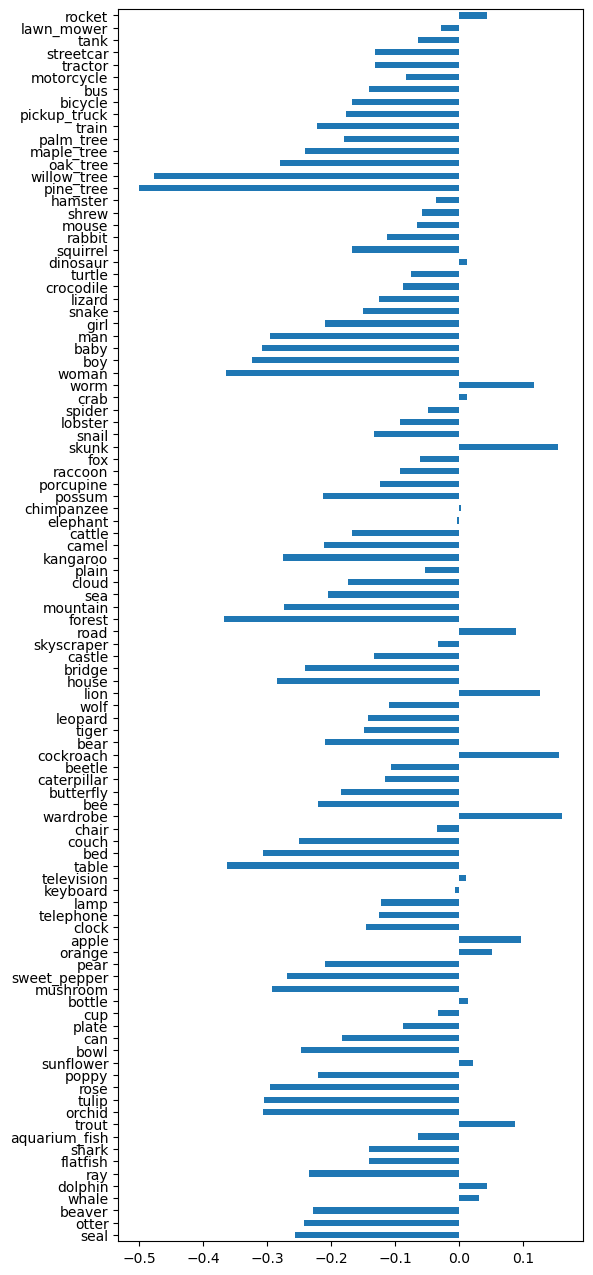

In [63]:
df.sort_values(by=['c_label', 'F_CF'],ascending=True).plot.barh(y='F_CF', x='label', legend=False, figsize=(6, 16), ylabel='')

График отображает разницу в точности классификации между узкими и широкими классами в нейронной сети. Он позволяет оценить, насколько нейронная сеть успешно распознает конкретные подклассы внутри более общих классов. Наибольший разброс имеют элементы широкого класса деревьев (trees) и людей (people), это говорит о том, что конкретный вид деревьев и людей между собой данная сеть определяет плохо.

С другой стороны, наименьшее отклонение в точности классификации наблюдается для узких классов, таких как lawn_mover, turtle, worm, plain, road, keyboard, telephone, plate, bottle, такие сеть определяет хорошо.

Иными словами, сеть более надежно и точно классифицирует узкие классы, в то время как у нее возникают трудности в распознавании более широких классов, где есть больше вариаций и разнообразия между конкретными видами объектов.

График различия точности распознавания узкого класса и точности распознавания широкого класса

<Axes: >

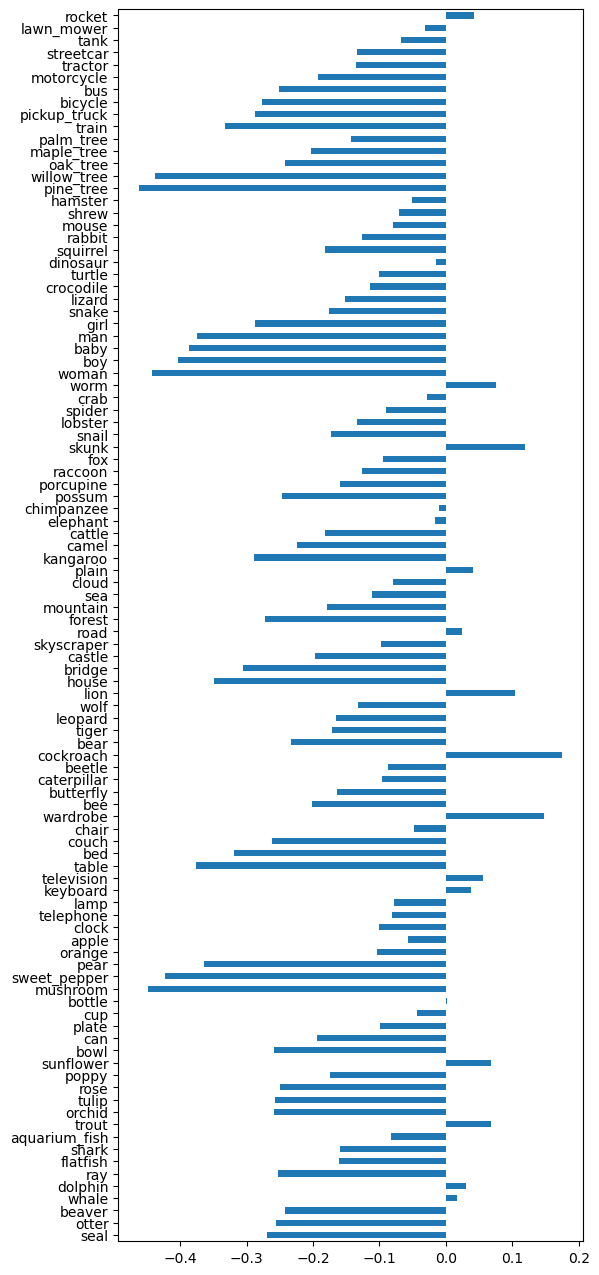

In [64]:
df.sort_values(by=['c_label', 'F_C'],ascending=True).plot.barh(y='F_C', x='label', legend=False, figsize=(6, 16), ylabel='')

График исследует различия в точности классификации между узкими и широкими классами в модели и позволяет сделать вывод о том, насколько успешно модель распознает более широкие классы по сравнению с узкими классами. Например, изображение сосны (pine_tree) в случае определения по широкому классу определяется лучше, чем по узкому. А изображения динозавра (dinosaur), дикообраза (porcupine), облака (cloud), дороги (road) определяются с примерно одинаковой точностью, как в случае распознавания по узкому классу, так и по широкому.
Таким образом, график дает нам информацию о том, как модель проявляет свои способности в распознавании разных классов в зависимости от их ширины и сложности.

График различия точности распознавания широкого класса по узкому и точности распознавания широкого класса

<Axes: >

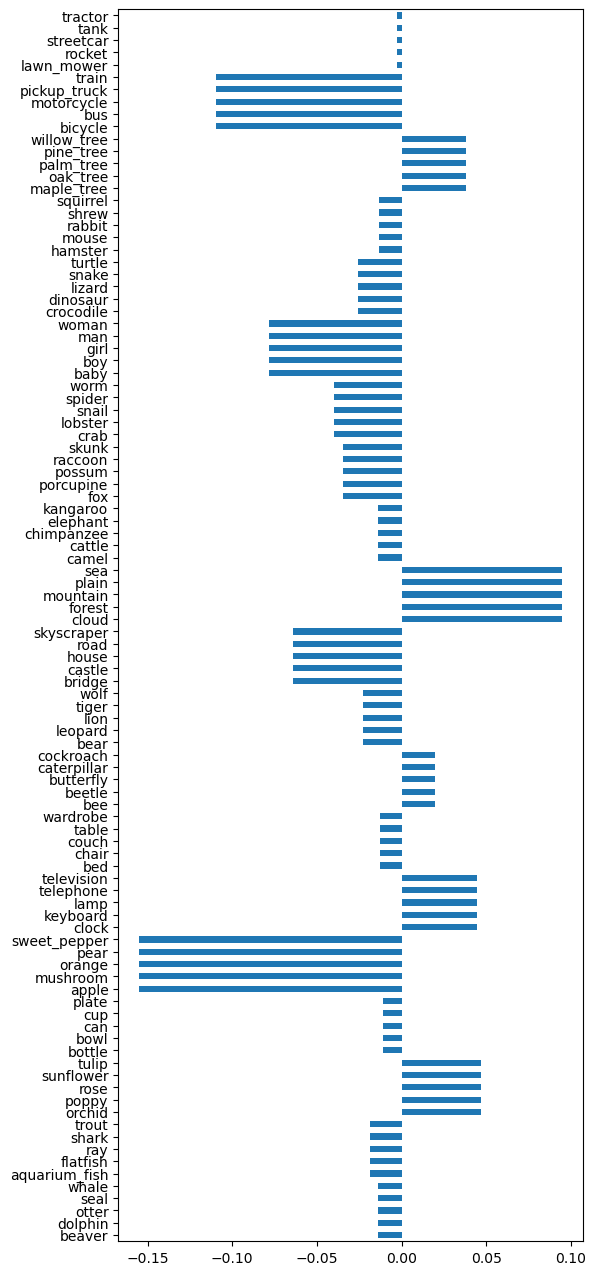

In [65]:
df.sort_values(by=['c_label', 'CF_C'],ascending=True).plot.barh(y='CF_C', x='label', legend=False, figsize=(6, 16), ylabel='')

График, который сравнивает разницу в точности распознавания широких классов по сравнению с их распознаванием в рамках узких классов, позволяет сделать вывод о том, какие категории лучше распознаются при обучении на узких классах и какие при обучении на широких классах. На узких классах наблюдается лучшее качество распознавания (что выражается положительным значением на графике) для классов, таких как транспортные средства (vehicles_2), деревья, рептилии, беспозвоночные (кроме насекомых), природные сцены, контейнеры для пищи, водные млекопитающие и другие. В то время как другие классы показывают более высокую точность распознавания при обучении на широких классах.
Это говорит о том, что для некоторых категорий объектов, обучение на более узких классах (более специфичных) может привести к более точной классификации, в то время как для других категорий объектов, обучение на более широких классах (более общих) может быть более эффективным.